In [66]:
# 角速度の平面成分と加速度の平面成分を用いてZ軸を基準に原点で回転させることで歩行を補正する

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_fontja
import numpy as np
from scipy import signal

acce_file_path = './data/acc.csv'
gyro_file_path = './data/gyro.csv'

acce_data = pd.read_csv(acce_file_path,names=['timestamp','x','y','z'], header=0)
gyro_data = pd.read_csv(gyro_file_path,names=['timestamp','x','y','z'], header=0)

# 2sから9sまでのデータに絞る
acce_data = acce_data[(acce_data['timestamp'] >= 20.0) & (acce_data['timestamp'] <= 90.0)]
gyro_data = gyro_data[(gyro_data['timestamp'] >= 20.0) & (gyro_data['timestamp'] <= 90.0)]
# indexをリセット
acce_data = acce_data.reset_index(drop=True)
gyro_data = gyro_data.reset_index(drop=True)

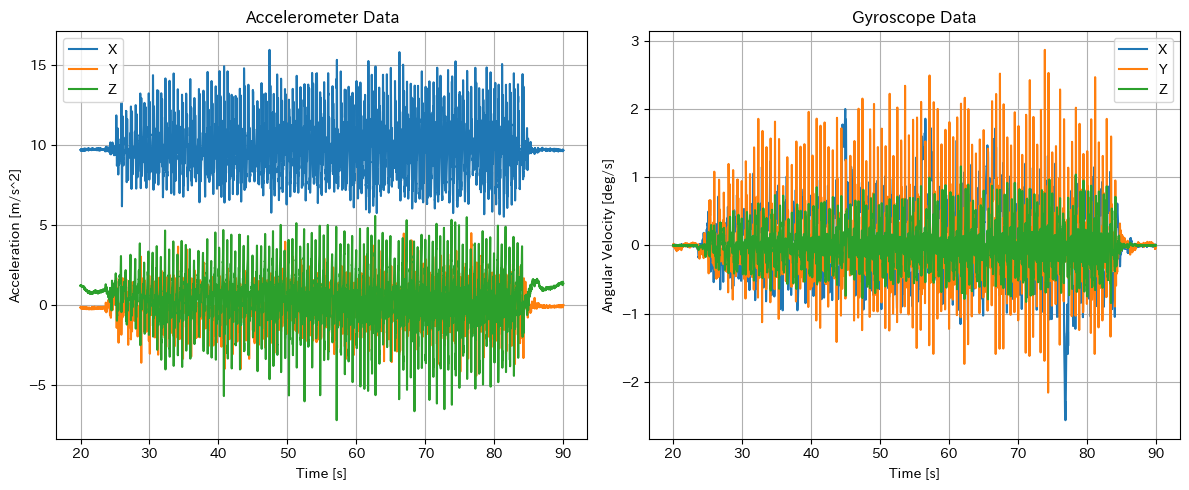

In [67]:
# 加速度と角速度のグラフを横に並べて表示
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 加速度
axes[0].plot(acce_data['timestamp'], acce_data['x'], label='X')
axes[0].plot(acce_data['timestamp'], acce_data['y'], label='Y')
axes[0].plot(acce_data['timestamp'], acce_data['z'], label='Z')
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Acceleration [m/s^2]')
axes[0].set_title('Accelerometer Data')
axes[0].legend()
axes[0].grid()

# 角速度
axes[1].plot(gyro_data['timestamp'], gyro_data['x'], label='X')
axes[1].plot(gyro_data['timestamp'], gyro_data['y'], label='Y')
axes[1].plot(gyro_data['timestamp'], gyro_data['z'], label='Z')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Angular Velocity [deg/s]')
axes[1].set_title('Gyroscope Data')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

## 加速度

X軸は重力加速度方向を向いている
平面加速度成分は(Y,Z)

## 角速度

加速度の値より、角速度の平面成分はX軸である


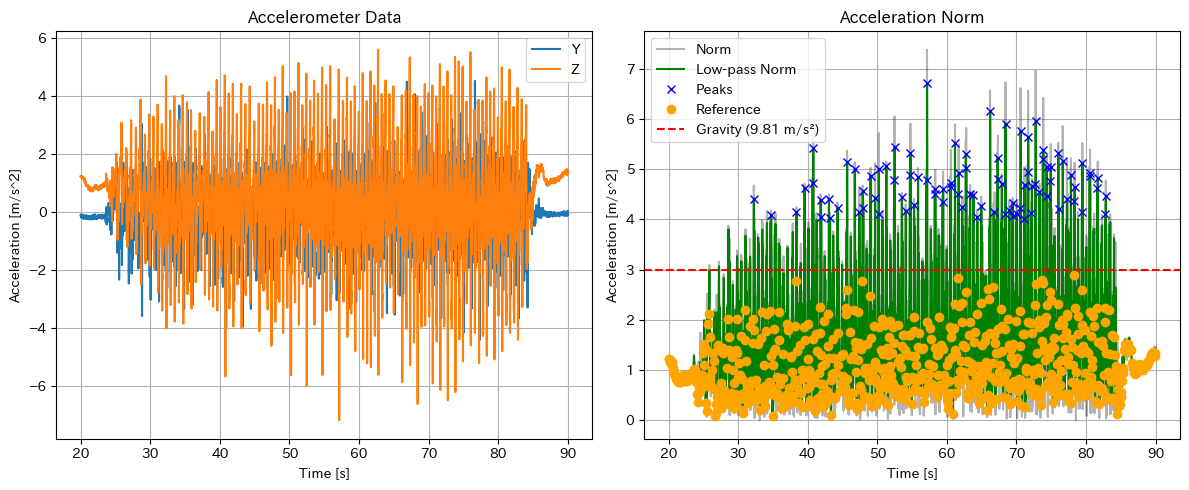

In [68]:
# ノルムの算出
acce_data['norm'] = np.sqrt(acce_data['y']**2 + acce_data['z']**2)
acce_data['low_norm'] = acce_data['norm'].rolling(window=10).mean()

peak,_ = signal.find_peaks(acce_data['low_norm'], height=4, distance=20)
gensoku_index = signal.find_peaks(-acce_data['low_norm'], height=-3, distance=20)[0]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 加速度
axes[0].plot(acce_data['timestamp'], acce_data['y'], label='Y')
axes[0].plot(acce_data['timestamp'], acce_data['z'], label='Z')
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Acceleration [m/s^2]')
axes[0].set_title('Accelerometer Data')
axes[0].legend()
axes[0].grid()

# ノルム
axes[1].plot(acce_data['timestamp'], acce_data['norm'], label='Norm', color='black', alpha=0.3)
axes[1].plot(acce_data['timestamp'], acce_data['low_norm'], label='Low-pass Norm', color='green')
axes[1].plot(acce_data['timestamp'].iloc[peak], acce_data['low_norm'].iloc[peak], 'x', label='Peaks', color='blue')
axes[1].plot(acce_data['timestamp'].iloc[gensoku_index], acce_data['low_norm'].iloc[gensoku_index], 'o', label='Reference', color='orange')
axes[1].axhline(y=3.0, color='red', linestyle='--', label='Gravity (9.81 m/s²)')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Acceleration [m/s^2]')
axes[1].set_title('Acceleration Norm')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

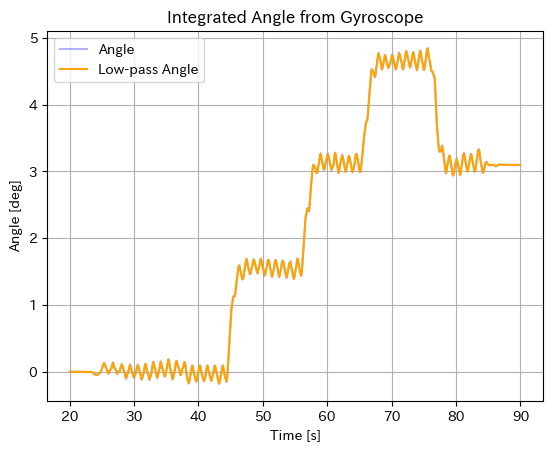

In [69]:
# 角速度の平面成分を積分して角度を求める
gyro_data['angle'] = np.cumsum(gyro_data['x']) / (len(gyro_data) / (gyro_data['timestamp'].iloc[-1] - gyro_data['timestamp'].iloc[0]))
gyro_data['low_angle'] = gyro_data['angle'].rolling(window=60, center=True).mean()

plt.plot(gyro_data['timestamp'], gyro_data['angle'], label='Angle', color='blue', alpha=0.3)
plt.plot(gyro_data['timestamp'], gyro_data['low_angle'], label='Low-pass Angle', color='orange')
plt.xlabel('Time [s]')
plt.ylabel('Angle [deg]')
plt.title('Integrated Angle from Gyroscope')
plt.legend()
plt.grid()
plt.show()

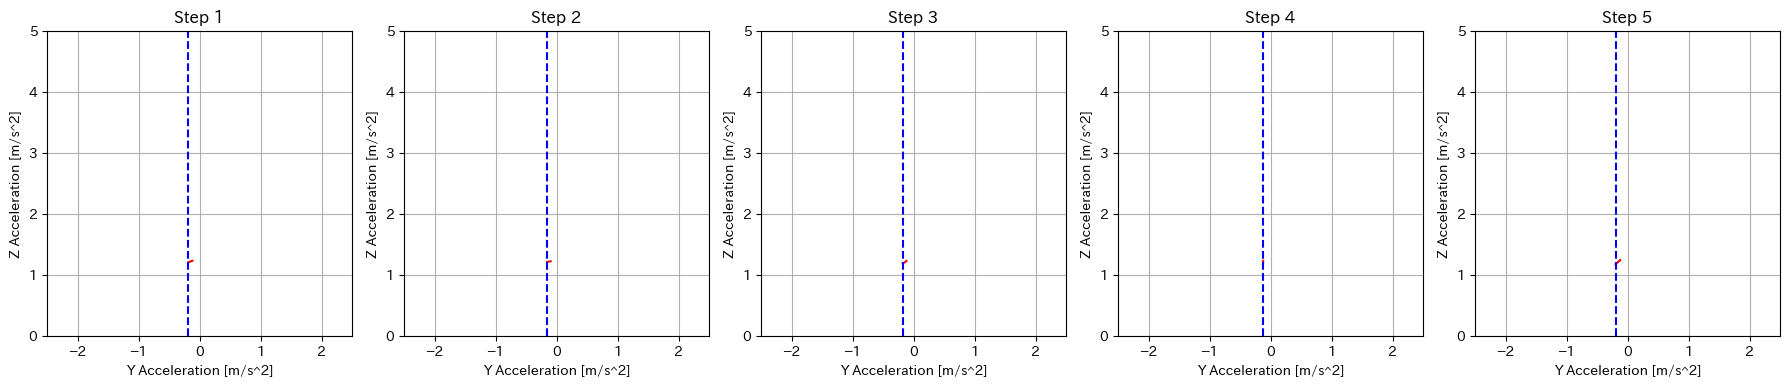

Peak 1: deg-0.06330428819606465,rad-0.0011048682596527099
Peak 2: deg-0.06210400194056719,rad-0.0010839193125278452
Peak 3: deg-0.1383151501345669,rad-0.0024140547752384708
Peak 4: deg-0.1103705532365462,rad-0.001926329551225415
Peak 5: deg-0.09938207960498531,rad-0.0017345445065860992
Peak 6: deg-0.13217745771251138,rad-0.0023069318339988963
Peak 7: deg-0.09525471138290578,rad-0.001662508341668627
Peak 8: deg-0.12343398943699008,rad-0.0021543295245473786
Peak 9: deg-0.12977558261220787,rad-0.002265011205276931
Peak 10: deg-0.16333075570441846,rad-0.0028506594568126127
Peak 11: deg-0.12704630488654026,rad-0.0022173763227626886
Peak 12: deg1.142437784827164,rad0.01993930084442453
Peak 13: deg1.4026374864278275,rad0.024480642350062868
Peak 14: deg1.6748985874742164,rad0.02923249498842733
Peak 15: deg1.4973083185388305,rad0.026132960076002645
Peak 16: deg1.470715610833801,rad0.025668829769529417
Peak 17: deg1.5184554339070624,rad0.026502046866477384
Peak 18: deg1.6821353821594462,rad0.029

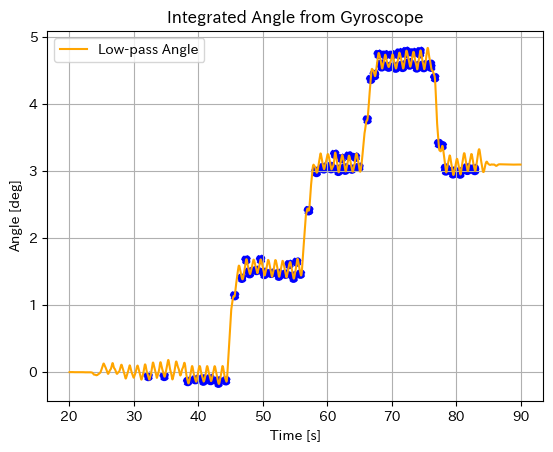

In [70]:
# 一歩ずつの加速度の方向をプロットする

fig, axes = plt.subplots(1,5,figsize=(18, 6))
for i in range(5):
	second_i = gensoku_index[i]
	# axes[i].quiver(acce_data['y'].iloc[i], acce_data['z'].iloc[i], acce_data['y'].iloc[second_i] - acce_data['y'].iloc[i], acce_data['z'].iloc[second_i] - acce_data['z'].iloc[i], angles='xy', scale_units='xy', scale=1, color='red')
	axes[i].plot([acce_data['y'].iloc[i], acce_data['y'].iloc[second_i]], [acce_data['z'].iloc[i], acce_data['z'].iloc[second_i]], color='red')
	axes[i].vlines(acce_data['y'].iloc[second_i], 0, 5, colors='blue', linestyles='dashed', label='Y=1')
	# z軸を基準に回転させる

	axes[i].set_xlim(-2.5, 2.5)
	axes[i].set_ylim(0, 5)
	axes[i].set_xlabel('Y Acceleration [m/s^2]')
	axes[i].set_ylabel('Z Acceleration [m/s^2]')
	axes[i].set_title(f'Step {i+1}')
	axes[i].grid()
	axes[i].set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

plt.plot(gyro_data['timestamp'], gyro_data['low_angle'], label='Low-pass Angle', color='orange')
for i in range(len(peak)):
	plt.scatter(gyro_data['timestamp'].iloc[peak[i]], gyro_data['low_angle'].iloc[peak[i]], color='blue', linestyle='dashed')
	print(f"Peak {i+1}: deg{gyro_data['low_angle'].iloc[peak[i]]},rad{np.deg2rad(gyro_data['low_angle'].iloc[peak[i]])}")
plt.xlabel('Time [s]')
plt.ylabel('Angle [deg]')
plt.title('Integrated Angle from Gyroscope')
plt.legend()
plt.grid()
plt.show()

[-0.11681251  1.22978254  0.        ] [-0.18796722  1.20098996  0.        ]
[-0.09763381  1.22023443  0.        ] [-0.15445229  1.21000333  0.        ]
[-0.11841087  1.22484291  0.        ] [-0.1799219  1.1816235  0.       ]
[-0.12260833  1.22967695  0.        ] [-0.12666669  1.16266993  0.        ]
[-0.12238909  1.23927174  0.        ] [-0.19824489  1.17214099  0.        ]
[-0.13743323  1.22959707  0.        ] [-0.1318286   1.13389685  0.        ]
[-0.14557412  1.20574221  0.        ] [-0.21185452  1.13324911  0.        ]
[-0.15093213  1.19608899  0.        ] [-0.17884281  1.10091393  0.        ]
[-0.16065745  1.20562177  0.        ] [-0.19313323  1.0177112   0.        ]
[-0.15661879  1.21989803  0.        ] [-0.20269203  1.01398308  0.        ]
[-0.15102876  1.20565064  0.        ] [-0.16357378  0.92805476  0.        ]
[-0.15767809  1.21415336  0.        ] [-0.16757601  0.89783705  0.        ]
[-0.13757569  1.22407392  0.        ] [-0.15869806  0.89906968  0.        ]
[-0.14610833  1

/var/folders/pn/h8lfs5c967n_dt8sf6wp_kx00000gn/T/ipykernel_62257/1296111585.py:30: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


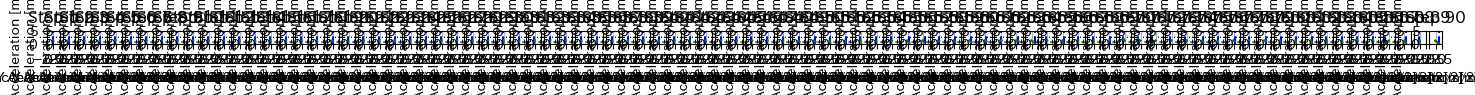

Peak 1: deg-0.06330428819606465,rad-0.0011048682596527099
Peak 2: deg-0.06210400194056719,rad-0.0010839193125278452
Peak 3: deg-0.1383151501345669,rad-0.0024140547752384708
Peak 4: deg-0.1103705532365462,rad-0.001926329551225415
Peak 5: deg-0.09938207960498531,rad-0.0017345445065860992
Peak 6: deg-0.13217745771251138,rad-0.0023069318339988963
Peak 7: deg-0.09525471138290578,rad-0.001662508341668627
Peak 8: deg-0.12343398943699008,rad-0.0021543295245473786
Peak 9: deg-0.12977558261220787,rad-0.002265011205276931
Peak 10: deg-0.16333075570441846,rad-0.0028506594568126127
Peak 11: deg-0.12704630488654026,rad-0.0022173763227626886
Peak 12: deg1.142437784827164,rad0.01993930084442453
Peak 13: deg1.4026374864278275,rad0.024480642350062868
Peak 14: deg1.6748985874742164,rad0.02923249498842733
Peak 15: deg1.4973083185388305,rad0.026132960076002645
Peak 16: deg1.470715610833801,rad0.025668829769529417
Peak 17: deg1.5184554339070624,rad0.026502046866477384
Peak 18: deg1.6821353821594462,rad0.029

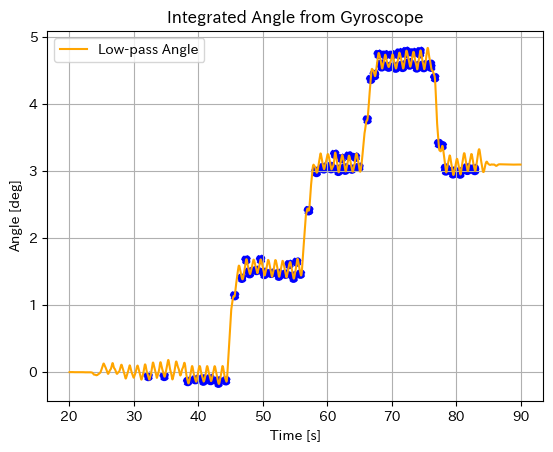

In [71]:
# 一歩ずつの加速度の方向をプロットする

fig, axes = plt.subplots(1,len(peak),figsize=(18, 6))
for i in range(peak.shape[0]):
	second_i = gensoku_index[i]
	axes[i].quiver(acce_data['y'].iloc[i], acce_data['z'].iloc[i], acce_data['y'].iloc[second_i] - acce_data['y'].iloc[i], acce_data['z'].iloc[second_i] - acce_data['z'].iloc[i], angles='xy', scale_units='xy', scale=1, color='red')
	axes[i].plot([acce_data['y'].iloc[i], acce_data['y'].iloc[second_i]], [acce_data['z'].iloc[i], acce_data['z'].iloc[second_i]], color='red')
	axes[i].vlines(acce_data['y'].iloc[second_i], 0, 5, colors='blue', linestyles='dashed', label='Y=1')
	# z軸を基準に回転させる

	start = np.array([acce_data['y'].iloc[i], acce_data['z'].iloc[i], 0])
	end = np.array([acce_data['y'].iloc[second_i], acce_data['z'].iloc[second_i], 0])
	shift_mat = np.array([[np.cos(np.deg2rad(-gyro_data['low_angle'].iloc[peak[i]])), -np.sin(np.deg2rad(-gyro_data['low_angle'].iloc[peak[i]])), 0],
						  [np.sin(np.deg2rad(-gyro_data['low_angle'].iloc[peak[i]])),  np.cos(np.deg2rad(-gyro_data['low_angle'].iloc[peak[i]])), 0],
						  [0, 0, 1]])
	shift_start = shift_mat @ start
	shift_end = shift_mat @ end
	print(shift_start, shift_end)
	axes[i].plot([shift_start[0], shift_end[0]], [shift_start[1], shift_end[1]], color='green')

	axes[i].set_xlim(-2.5, 2.5)
	axes[i].set_ylim(0, 5)
	# axes[i].set_xlim(-5, 5)
	# axes[i].set_ylim(-5, 5)
	axes[i].set_xlabel('Y Acceleration [m/s^2]')
	axes[i].set_ylabel('Z Acceleration [m/s^2]')
	axes[i].set_title(f'Step {i+1}')
	axes[i].grid()
	axes[i].set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

plt.plot(gyro_data['timestamp'], gyro_data['low_angle'], label='Low-pass Angle', color='orange')
for i in range(len(peak)):
	plt.scatter(gyro_data['timestamp'].iloc[peak[i]], gyro_data['low_angle'].iloc[peak[i]], color='blue', linestyle='dashed')
	print(f"Peak {i+1}: deg{gyro_data['low_angle'].iloc[peak[i]]},rad{np.deg2rad(gyro_data['low_angle'].iloc[peak[i]])}")
plt.xlabel('Time [s]')
plt.ylabel('Angle [deg]')
plt.title('Integrated Angle from Gyroscope')
plt.legend()
plt.grid()
plt.show()

Step 1: deg-247.96940624015207, rad-4.327882583106026
Step 2: deg-259.7923414452139, rad-4.534231729684306
Step 3: deg-234.90702406650976, rad-4.099901006022154
Step 4: deg-183.46595745421837, rad-3.2020850228999445
Step 5: deg-228.49185818787623, rad-3.9879352393784044
Step 6: deg-176.64832858901903, rad-3.083094952023211
Step 7: deg-222.43665671040003, rad-3.8822520367248194
Step 8: deg-196.34410809333787, rad-3.4268511531203916
Step 9: deg-189.80532632068082, rad-3.3127278821181347
Step 10: deg-192.61213328423682, rad-3.3617159051000916
Step 11: deg-182.58753179922152, rad-3.1867536029862618
Step 12: deg-181.79226915448237, rad-3.1728736514174454
Step 13: deg-183.71848451147164, rad-3.206492451499386
Step 14: deg-173.08738329450355, rad-3.020944732150517
Step 15: deg-180.59184680124858, rad-3.1519223289389773
Step 16: deg-185.5434458008872, rad-3.238344034721129
Step 17: deg-179.31898787900286, rad-3.129706749832403
Step 18: deg-178.2260536278168, rad-3.1106314486413877
Step 19: deg

/var/folders/pn/h8lfs5c967n_dt8sf6wp_kx00000gn/T/ipykernel_62257/1785700773.py:41: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


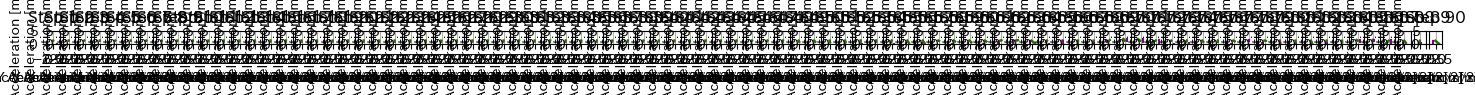

In [72]:
# 一歩ずつの加速度の方向をプロットする

fig, axes = plt.subplots(1,len(peak),figsize=(18, 6))
rad_angle_list = []
for i in range(peak.shape[0]):
	second_i = gensoku_index[i]
	axes[i].quiver(acce_data['y'].iloc[i], acce_data['z'].iloc[i], acce_data['y'].iloc[second_i] - acce_data['y'].iloc[i], acce_data['z'].iloc[second_i] - acce_data['z'].iloc[i], angles='xy', scale_units='xy', scale=1, color='red')
	axes[i].plot([acce_data['y'].iloc[i], acce_data['y'].iloc[second_i]], [acce_data['z'].iloc[i], acce_data['z'].iloc[second_i]], color='red')
	# axes[i].vlines(acce_data['y'].iloc[second_i], 0, 5, colors='blue', linestyles='dashed', label='Y=1')

	start = np.array([acce_data['y'].iloc[i], acce_data['z'].iloc[i], 0])
	end = np.array([acce_data['y'].iloc[second_i], acce_data['z'].iloc[second_i], 0])
	shift_mat = np.array([[np.cos(np.deg2rad(-gyro_data['low_angle'].iloc[peak[i]])), -np.sin(np.deg2rad(-gyro_data['low_angle'].iloc[peak[i]])), 0],
						  [np.sin(np.deg2rad(-gyro_data['low_angle'].iloc[peak[i]])),  np.cos(np.deg2rad(-gyro_data['low_angle'].iloc[peak[i]])), 0],
						  [0, 0, 1]])
	shift_start = shift_mat @ start
	shift_end = shift_mat @ end
	axes[i].plot([shift_start[0], shift_end[0]], [shift_start[1], shift_end[1]], color='green')

	# y軸に直行するように回転させる
	rad_angle = np.arctan2(shift_end[1] - shift_start[1], shift_end[0] - shift_start[0]) - np.pi/2
	# rad_angle = np.arctan2(shift_end[1] - shift_start[1], shift_end[0] - shift_start[0])
	rad_angle_list.append(rad_angle)
	print(f"Step {i+1}: deg{np.rad2deg(rad_angle)}, rad{rad_angle}")
	shift_rad_angle_mat = np.array([[np.cos(-rad_angle), -np.sin(-rad_angle), 0],
									[np.sin(-rad_angle),  np.cos(-rad_angle), 0],
									[0, 0, 1]])
	shift_rad_angle_start = shift_rad_angle_mat @ shift_start
	shift_rad_angle_end = shift_rad_angle_mat @ shift_end
	axes[i].plot([shift_rad_angle_start[0], shift_rad_angle_end[0]], [shift_rad_angle_start[1], shift_rad_angle_end[1]], color='purple')

	axes[i].set_xlim(-2.5, 2.5)
	axes[i].set_ylim(0, 5)
	# axes[i].set_xlim(-5, 5)
	# axes[i].set_ylim(-5, 5)
	axes[i].set_xlabel('Y Acceleration [m/s^2]')
	axes[i].set_ylabel('Z Acceleration [m/s^2]')
	axes[i].set_title(f'Step {i+1}')
	axes[i].grid()
	axes[i].set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

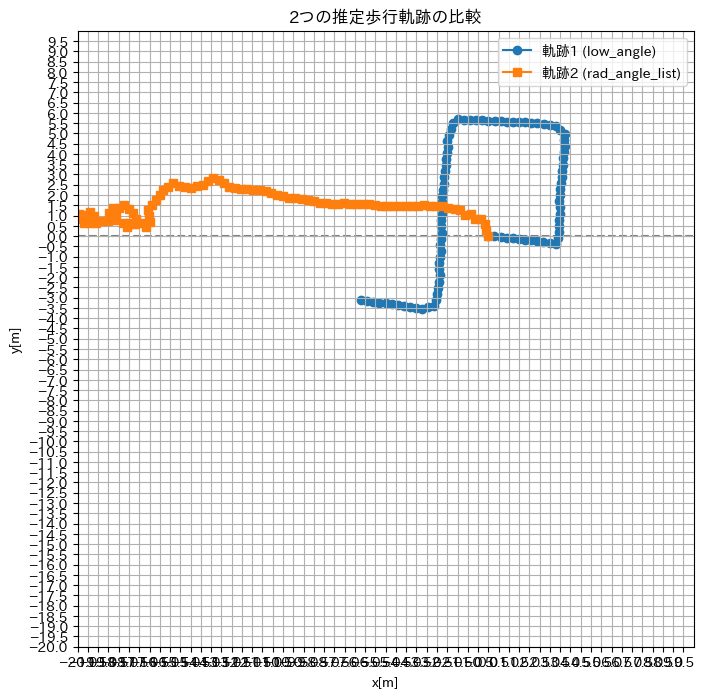

In [73]:
step = 0.3
point = [[0, 0]]
point_only_pdr = [[0, 0]]

# ステップから歩行軌跡を計算(rad_angle_list)
for p in range(len(peak)):
    # 軌跡1: gyro_data['low_angle'] を使用
    x1 = step * np.cos(gyro_data['low_angle'][peak[p]]) + point[-1][0]
    y1 = step * np.sin(gyro_data['low_angle'][peak[p]]) + point[-1][1]
    point.append([x1, y1])
    
    # 軌跡2: rad_angle_list を使用
    x2 = step * np.cos(rad_angle_list[p]) + point_only_pdr[-1][0]
    y2 = step * np.sin(rad_angle_list[p]) + point_only_pdr[-1][1]
    point_only_pdr.append([x2, y2])

# 2つの軌跡をそれぞれDataFrameに変換
point = pd.DataFrame(data=point, columns=['x', 'y'])
point_only_pdr = pd.DataFrame(data=point_only_pdr, columns=['x', 'y'])

# 2つの軌跡の始点を(0,0)に補正
point['x'] = point['x'] - point['x'][0]
point['y'] = point['y'] - point['y'][0]
point_only_pdr['x'] = point_only_pdr['x'] - point_only_pdr['x'][0]
point_only_pdr['y'] = point_only_pdr['y'] - point_only_pdr['y'][0]


# --- 描画 ---
size = ((-20, 10), (-20, 10))
plt.figure(figsize=(10, 8)) # グラフサイズを少し大きく

# ★★★ 2つの軌跡をプロット ★★★
plt.plot(point['x'], point['y'], 'o-', label='軌跡1 (low_angle)', zorder=1)
plt.plot(point_only_pdr['x'], point_only_pdr['y'], 's-', label='軌跡2 (rad_angle_list)', zorder=2)


# 軸を揃える
plt.gca().set_aspect('equal', adjustable='box')

plt.title('2つの推定歩行軌跡の比較')
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.xticks(np.arange(size[0][0], size[0][1], 0.5))
plt.yticks(np.arange(size[1][0], size[1][1], 0.5))
plt.hlines(0, size[0][0], size[0][1], colors='gray', linestyles='--', zorder=0)
plt.xlim(size[0][0], size[0][1])
plt.ylim(size[1][0], size[1][1])

plt.grid()
plt.legend() # 凡例を表示
plt.show()